In [1]:
# for loading and manipulating dataframes
import pandas as pd

# for various plotting functions
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# to scale our data so that we can perform "sensible" clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# to provide an implementation of the k-means algorithm
from sklearn.cluster import KMeans

import numpy as np
from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [2]:
pots = pd.read_csv("Pots_clean.csv")
pots.head()

,productcode,price,maker,name,description,height,width,depth,materials,technique,firing,decoration
0,AM470Y165,47.0,Andy Mason,ovalled bowl cream satin motif,this stoneware bowl is wheel-thrown with a cre...,8.0,25.5,22.0,Stoneware,Thrown,Electric,Glaze
1,AM470Y164,47.0,Andy Mason,ovalled bowl cream satin motif,this stoneware bowl is wheel-thrown with a cre...,8.0,25.0,22.0,Stoneware,Thrown,Electric,Glaze
2,AM470Y163,38.0,Andy Mason,dinner plate cream satin plain,this stoneware plate is wheel-thrown with a cr...,3.0,25.0,15.3,Stoneware,Thrown,Electric,Glaze
3,AM470Y162,38.0,Andy Mason,dinner plate cream satin plain,this stoneware plate is wheel-thrown with a cr...,3.0,25.0,15.3,Stoneware,Thrown,Electric,Glaze
4,AM470Y161,38.0,Andy Mason,dinner plate cream satin plain,this stoneware plate is wheel-thrown with a cr...,3.0,24.5,15.1,Stoneware,Thrown,Electric,Glaze


In [3]:
# drop variables that are unnecessary to cluster with
pots_final = pots.drop(columns = ["productcode", "name", "description", "maker"])

# columns to be scaled
cols = ["price", "height", "depth", "width"]

scaler = StandardScaler()

pots_final[cols] = pd.DataFrame(scaler.fit_transform(pots[cols]), columns = cols)
pots_final.head(2)

,price,height,width,depth,materials,technique,firing,decoration
0,-0.564882,-0.69404,1.085478,2.097354,Stoneware,Thrown,Electric,Glaze
1,-0.564882,-0.69404,1.025789,2.097354,Stoneware,Thrown,Electric,Glaze


In [4]:
#print out indexes of columns so as to easily refernce categorical columns (for Kprototypes)
for i in pots_final.columns:
    print('{}:'.format(i), pots_final.columns.get_loc(i))

price: 0
height: 1
width: 2
depth: 3
materials: 4
technique: 5
firing: 6
decoration: 7


In [5]:
categorical_columns = [4, 5, 6, 7]

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14


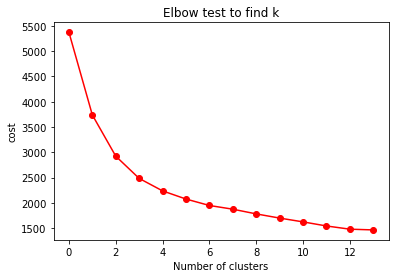

In [6]:
#run an elbow curve of Kprototypes
cost = []
for i_clus in range(1, 15):
        kprototype = KPrototypes(n_clusters = i_clus, init='Huang')
        kprototype.fit_predict(pots_final, categorical=categorical_columns)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(i_clus))
    
plt.plot( cost, 'ro-', label="cost")
plt.title("Elbow test to find k")
plt.xlabel("Number of clusters")
plt.ylabel("cost")
plt.show()

An arbitrary choice, and 3 would be the 'elbow', but 5 categories may be a bit more workable in terms of insights.

In [7]:
kprototype = KPrototypes(n_clusters = 5, init = 'Huang', n_init = 10)
kprototype.fit_predict(pots_final, categorical=categorical_columns)

#Checks of success
print(kprototype.labels_)
print(len(kprototype.labels_))

[0 0 2 ... 2 3 3]
1126


In [8]:
#append cluster labels to main dataset 'pots' and create new category
pots["cluster labels"] = kprototype.labels_
pots['category'] = pots['cluster labels'].map({0:'first', 1:'second', 2:'third', 3:'fourth', 4:'fifth'})
pots.sample(3)

,productcode,price,maker,name,description,height,width,depth,materials,technique,firing,decoration,cluster labels,category
501,AL286Y1292,35.0,Anja Lubach,Small Madonna Vessel,"porcelain vessel, the symmetry of which is alt...",6.0,9.0,8.5,Porcelain,Thrown,Electric,Glaze,3,fourth
464,SF209Y767,73.0,Sotis Filippides,Bowl,a finely thrown stoneware round bowl with a sa...,6.0,12.0,9.8,Stoneware,Thrown,Electric,Glaze,3,fourth
463,SF209Y771,73.0,Sotis Filippides,Bowl,a finely thrown stoneware round bowl with a sa...,6.5,12.5,10.0,Stoneware,Thrown,Electric,Glaze,3,fourth


In [9]:
#use a rename 'count' column to count data points per cluster.
pots.rename(columns = {'cluster labels':'count'}, inplace = True)
pots.groupby('category').agg(
    {
        'count':'count',
        'materials': lambda x: x.value_counts().index[0], #showcase the category of greatest incidence
        'technique': lambda x: x.value_counts().index[0], #as above etc.
        'firing': lambda x: x.value_counts().index[0],
        'decoration': lambda x: x.value_counts().index[0],
        'price': 'mean',
        'height': 'mean',
        'width': 'mean',
        'depth': 'mean'
    }
).round(1).reset_index().sort_values("count")

,category,count,materials,technique,firing,decoration,price,height,width,depth
0,fifth,71,Stoneware,Hand built,Electric,Glaze,2084.0,33.1,28.3,16.5
1,first,120,Earthenware,Hand built,Electric,Glaze,365.4,9.6,30.5,20.7
3,second,215,Stoneware,Hand built,Electric,Glaze,515.3,28.5,17.5,10.8
4,third,249,Stoneware,Thrown,Electric,Glaze,164.6,10.0,18.1,13.1
2,fourth,471,Porcelain,Thrown,Electric,Glaze,124.9,11.0,9.6,8.2


<br>
Results are interesting! They seem to have clustered appropriately with nice sample sizes per cluster. Let's have a look at a pairplot to see if we can obtain any interpretability.
<br>

<br>

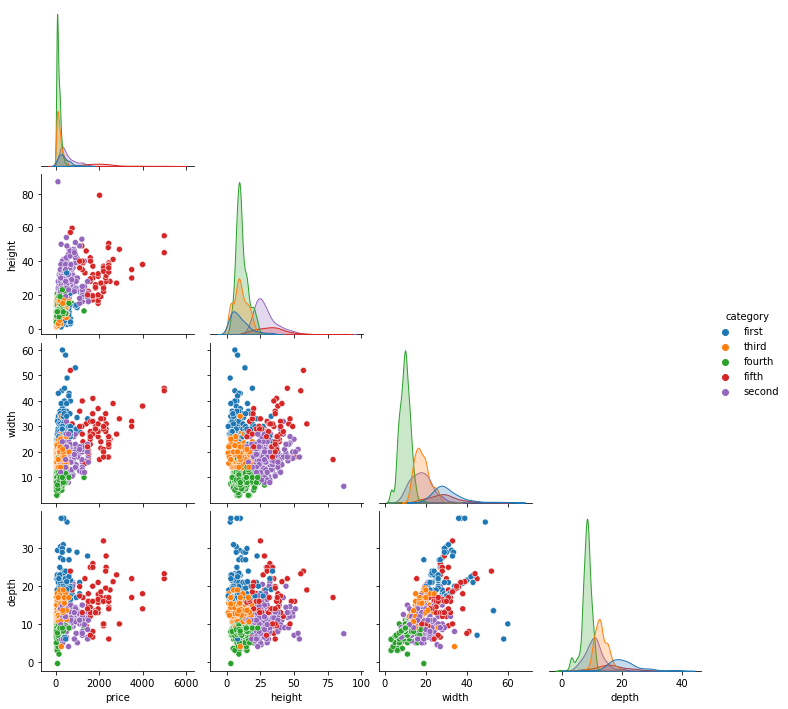

In [10]:
sns.pairplot(pots.drop(['count'],axis=1), corner = True, hue = 'category')

Not much to the above - Clusters have seperated to a certain degree but it might be interesting to carry out some dimensionality reduction for the sake of visualising our clusters a bit better.

I will encode the categorical variables and plus this into T-SNE and PCA

## T-SNE and PCA

In [11]:
pots_encoded = pd.get_dummies(pots_final)
print(pots_encoded.shape)
print(pots_encoded.columns)

(1126, 19)
Index(['price', 'height', 'width', 'depth', 'materials_Bone China',
       'materials_Earthenware', 'materials_Porcelain', 'materials_Stoneware',
       'technique_Hand built', 'technique_Thrown', 'firing_Electric',
       'firing_Gas', 'firing_Raku', 'firing_Wood', 'decoration_Glaze',
       'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata'],
      dtype='object')


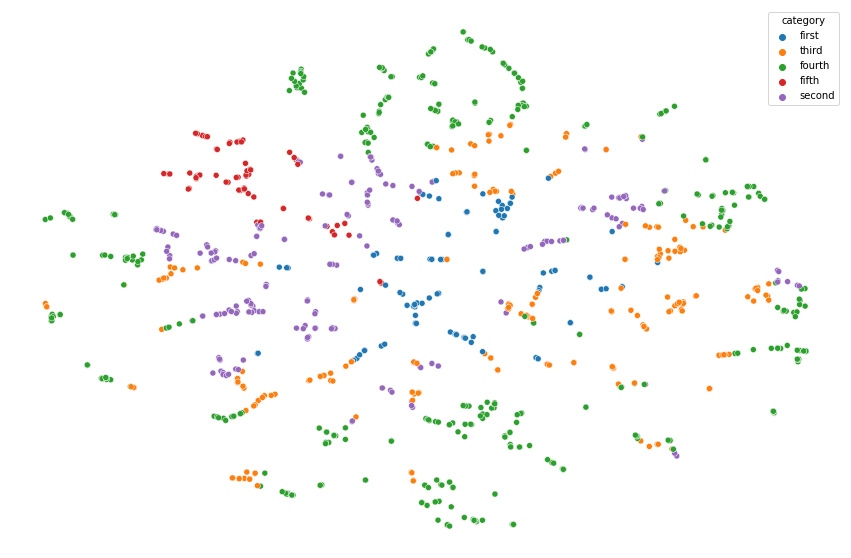

In [12]:
tsne = TSNE(perplexity=10, n_iter=300, init='random', random_state=137)

embed = tsne.fit_transform(pots_encoded)

plt.figure(figsize = (15, 10))
sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=pots.category)
plt.axis('off');

Results are interesting with T-SNE manifolds displaying some concentric circles of data. - Let's try a bit of a gridsearch to represent that more fully. This will allow me to gauge some of the 'success' in clustering.

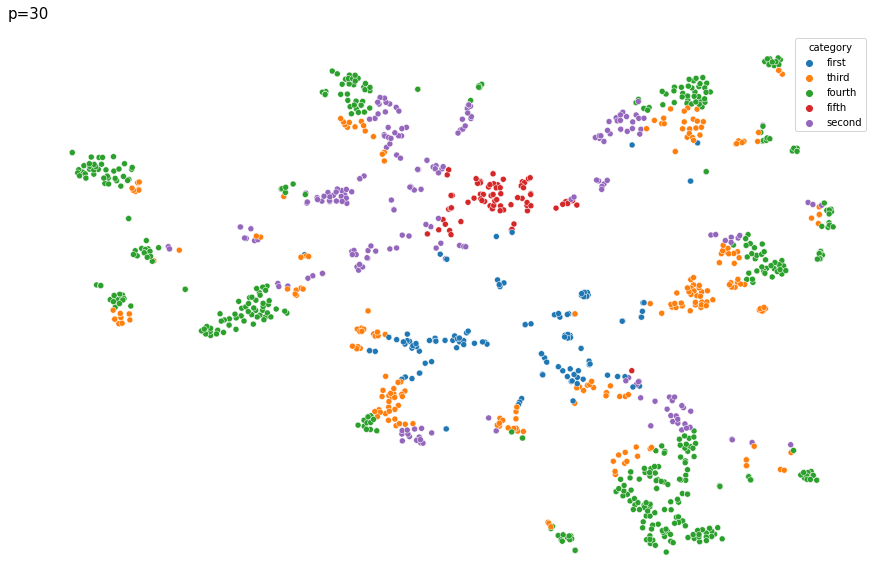

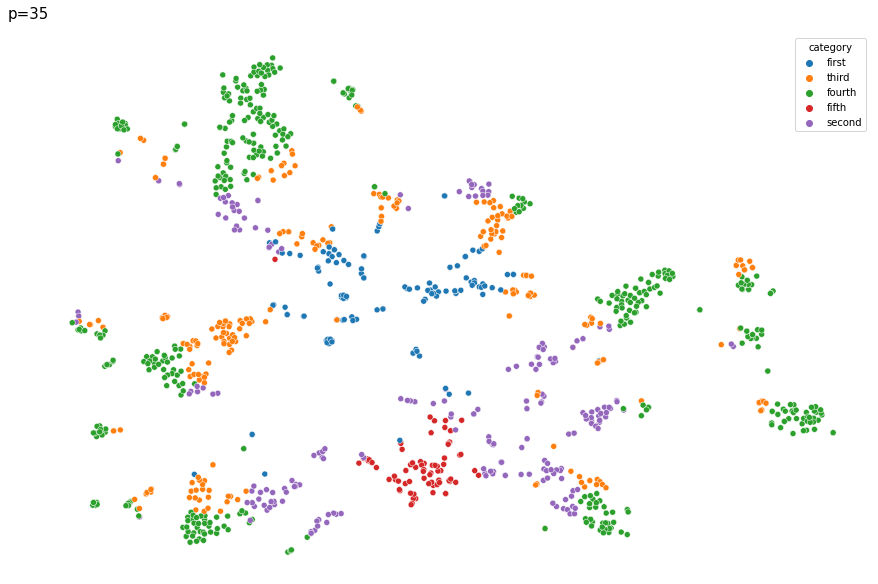

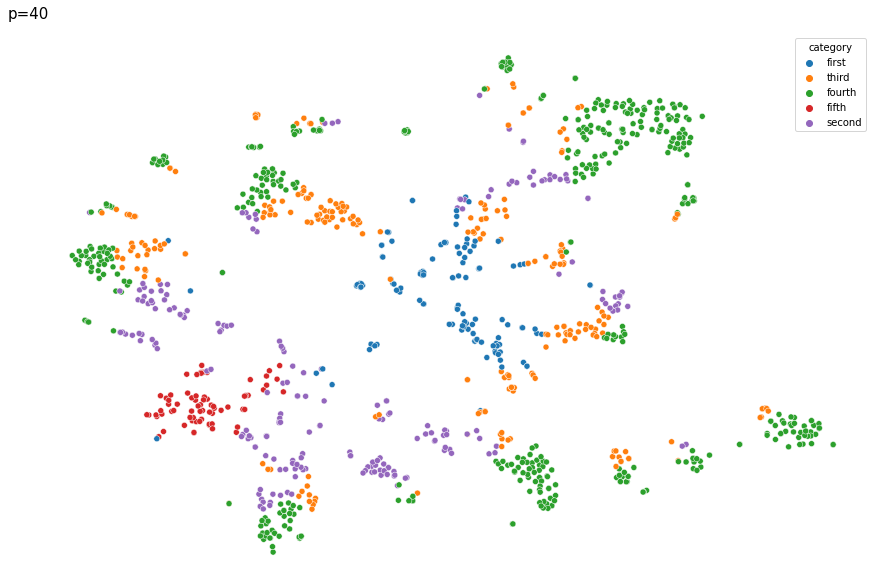

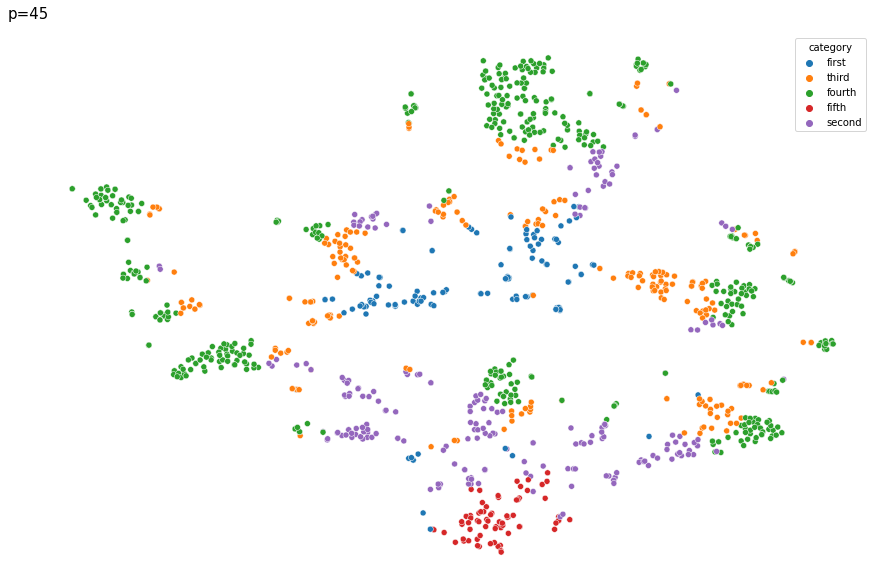

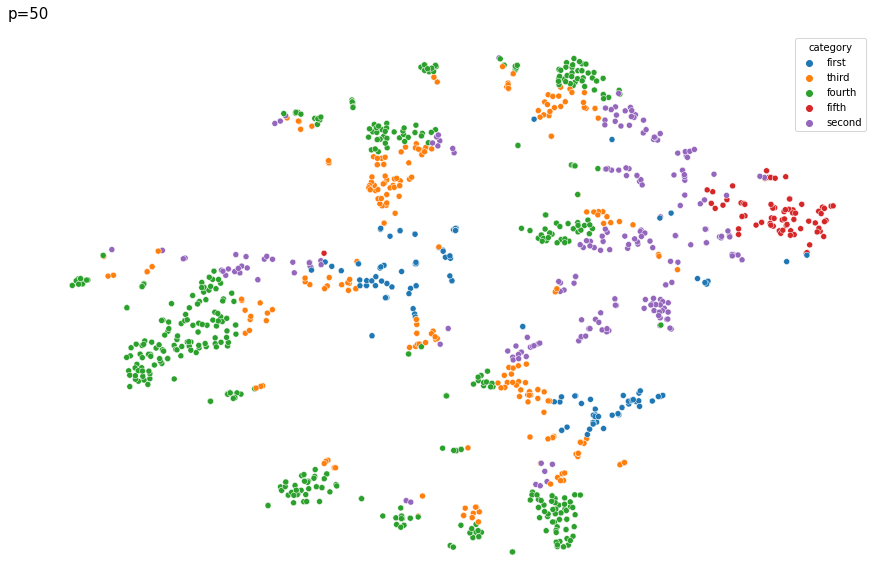

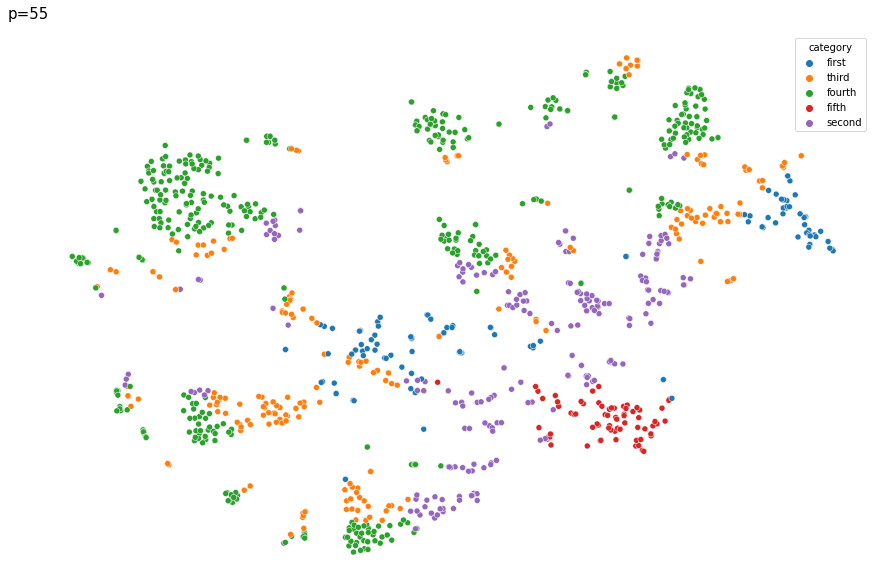

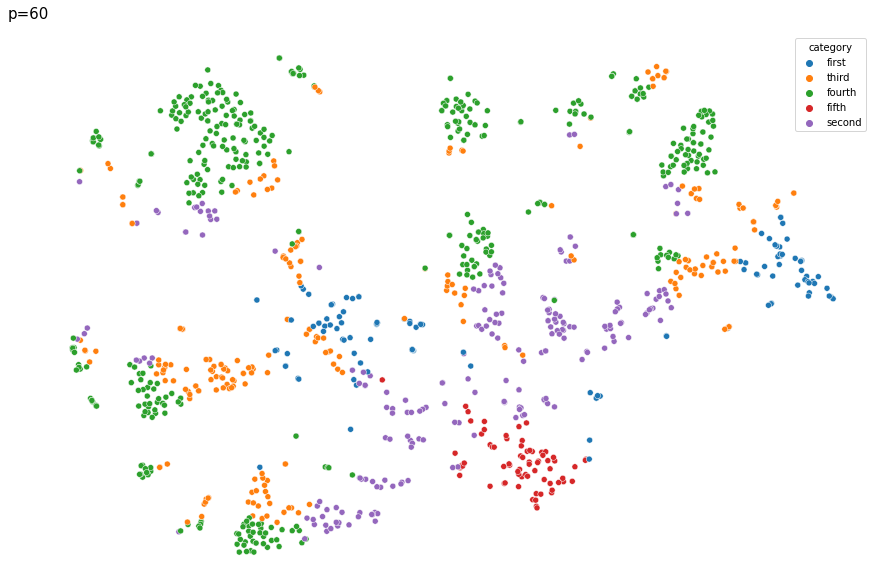

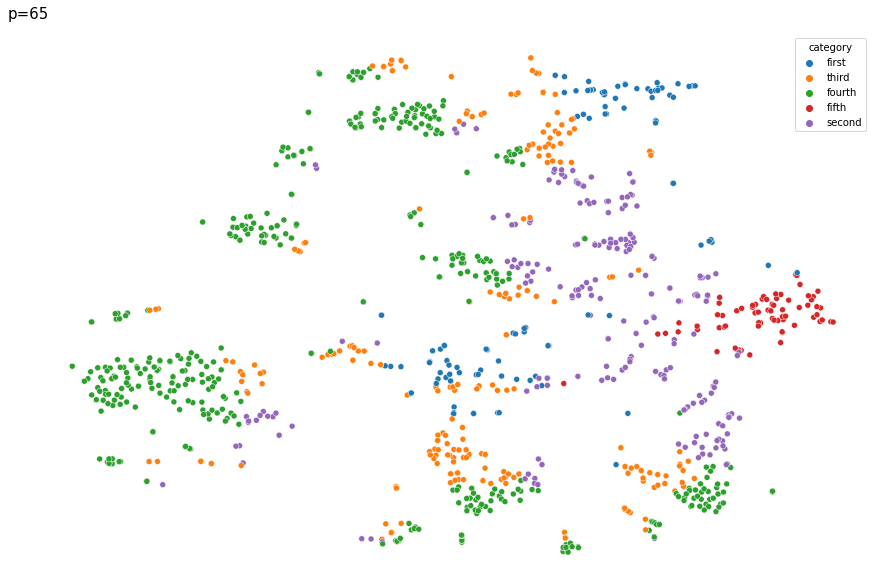

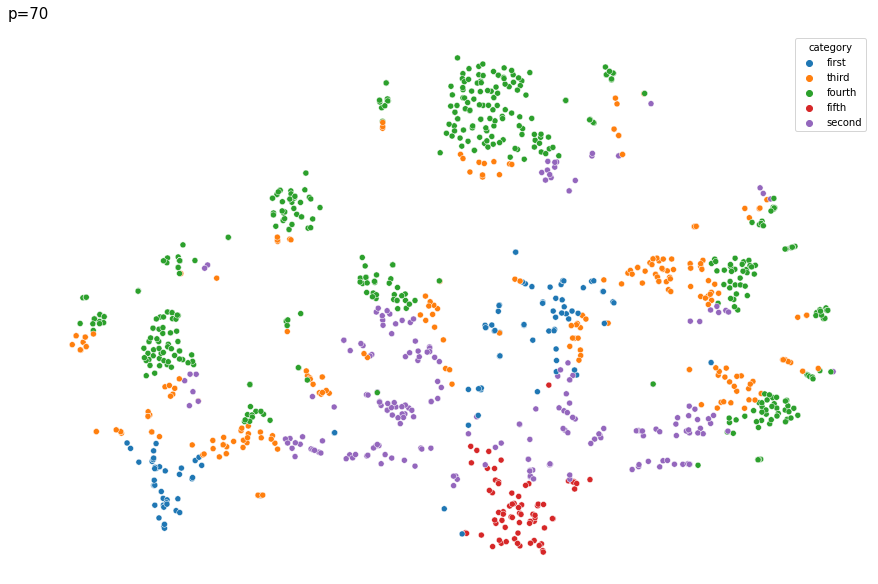

In [13]:
p_s = [30, 35, 40, 45, 50, 55, 60, 65, 70]

for i in p_s:
    tsne = TSNE(perplexity=i, n_iter=10000, init='random', random_state=137)

    embed = tsne.fit_transform(pots_encoded)

    fig, ax = plt.subplots(figsize = (15, 10))
    sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=pots.category)
    fig.text(0.1, 0.9, 'p={}'.format(str(i)), size=15)
    ax.axis('off');

Some interesting results that raise the question as to whether it would now be worth clustering based on the t-SNE'd data. But let's check PCA first

<AxesSubplot:>

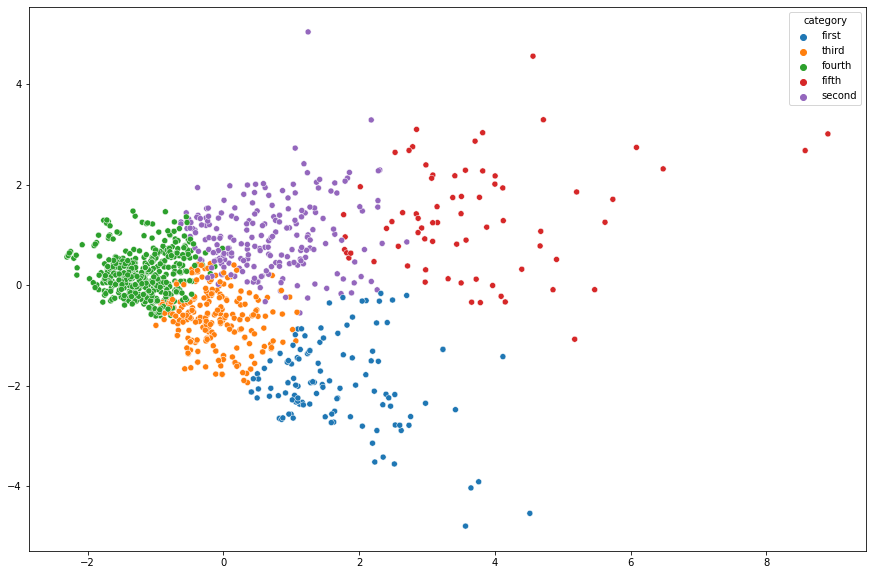

In [14]:
pca = PCA(n_components=2)
embed = pca.fit_transform(pots_encoded)

plt.figure(figsize = (15, 10))
sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=pots.category)

In [15]:
pca.explained_variance_ratio_

array([0.37393992, 0.20307272])

PCA explains 0.57 - 57% of the variance at n=2 components. PCA shows interesting results of clustering where even with dimensionality reduction the clusters are well preserved. There is some overlap between clusters but that could be as a result of the dimensionality reduction.

## Interpreting clusters (renamed as 'category')

In [16]:
pots.rename(columns = {'cluster labels':'count'}, inplace = True)
pots.groupby('category').agg(
    {
        'count':'count',
        'materials': lambda x: x.value_counts().index[0],
        'technique': lambda x: x.value_counts().index[0],
        'firing': lambda x: x.value_counts().index[0],
        'decoration': lambda x: x.value_counts().index[0],
        'price': 'mean',
        'height': 'mean',
        'width': 'mean',
        'depth': 'mean'
    }
).round(1).reset_index()

,category,count,materials,technique,firing,decoration,price,height,width,depth
0,fifth,71,Stoneware,Hand built,Electric,Glaze,2084.0,33.1,28.3,16.5
1,first,120,Earthenware,Hand built,Electric,Glaze,365.4,9.6,30.5,20.7
2,fourth,471,Porcelain,Thrown,Electric,Glaze,124.9,11.0,9.6,8.2
3,second,215,Stoneware,Hand built,Electric,Glaze,515.3,28.5,17.5,10.8
4,third,249,Stoneware,Thrown,Electric,Glaze,164.6,10.0,18.1,13.1


Check to make sure that the primary category in 'materials', 'technique', 'firing' and 'decoration' is justified

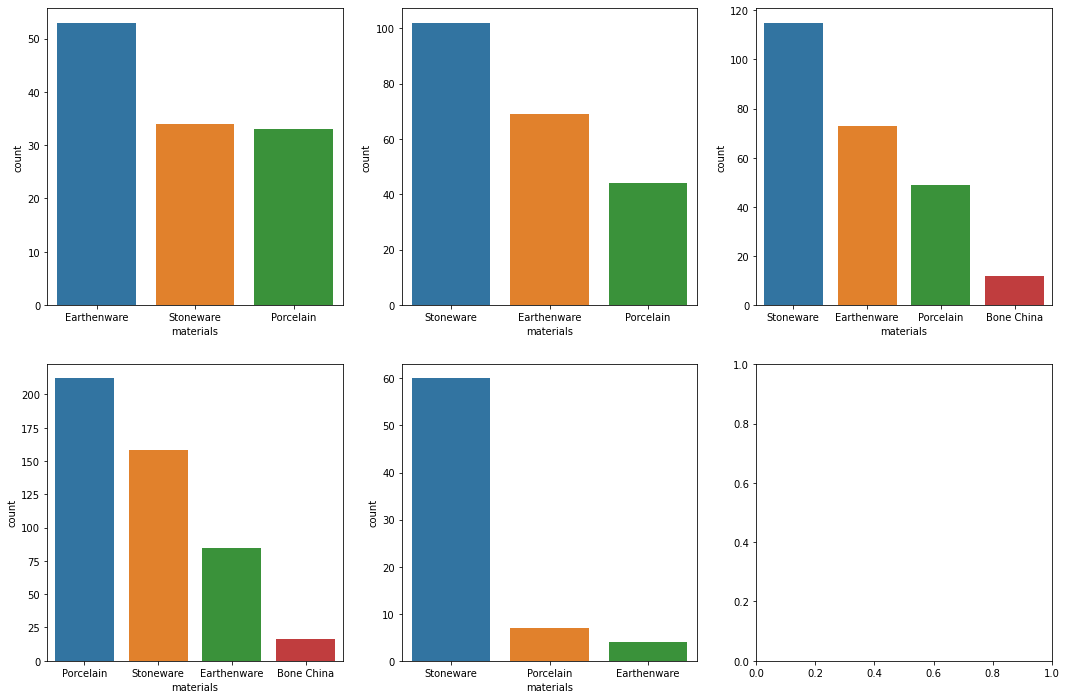

In [17]:
categories = ['first', 'second', 'third', 'fourth', 'fifth']


fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i in range(len(categories)):
    bars = pots.loc[pots["category"]==categories[i], 'materials']
    bars = bars.reset_index(name='materials').groupby("materials").size()
    bars = bars.reset_index(name='count').sort_values("count", ascending = False)
    sns.barplot(x="materials", y="count", data=bars, ax=axs.ravel()[i])
    ax = axs.ravel()[i]


Seems to be that the clusters are well motivated and the inspection of the table above works well given that the most common material tends to be distinguishably more common than the subsequent materials. this is particularly the case with the fourth cluster.

'first' — small, thrown porcelain

'second' — small, thrown stoneware

'third' — medium, hand built

'fourth' — large, ornate hand built

'fifth' — large, flat hand built earthenware

In [18]:
pots.drop(columns='count', inplace = True)

In [21]:
pots = pots.set_index('productcode')

In [22]:
pots.to_csv("Pots_clean_labelled.csv")